<a href="https://colab.research.google.com/github/jchelp/aula37/blob/main/2-3-3-ExploringConvolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##What are Convolutions?

What are convolutions? In this lab you'll explore what they are and how they work. In later lessons, you'll see how to use them in your neural network.

Together with convolutions, you'll use something called 'Pooling', which compresses your image, further emphasising the features. You'll also see how pooling works in this lab.

##Limitations of the previous DNN
In an earlier exercise you saw how to train an image classifier for fashion items using the Fashion MNIST dataset. This gave you a pretty accuract classifier, but there was an obvious constraint: the images were 28x28, grey scale and the item was centered in the image.

For example here are a couple of the images in Fashion MNIST
![Picture of a sweater and a boot](https://cdn-images-1.medium.com/max/1600/1*FekMt6abfFFAFzhQcnjxZg.png)

The DNN that you created simply learned from the raw pixels what made up a sweater, and what made up a boot in this context. But consider how it might classify this image?

![image of boots](https://cdn.pixabay.com/photo/2013/09/12/19/57/boots-181744_1280.jpg)

(Image is Public domain CC0 from Pixabay: https://pixabay.com/photos/boots-travel-railroad-tracks-181744/)

While it's clear that there are boots in this image, the classifier would fail for a number of reasons. First, of course, it's not 28x28 greyscale, but more importantly, the classifier was trained on the raw pixels of a left-facing boot, and not the features that make up what a boot is.

That's where Convolutions are very powerful. A convolution is a filter that passes over an image, processing it, and extracting features that show a commonolatity in the image. In this lab you'll see how they work, but processing an image to see if you can extract features from it!




Generating convolutions is very simple -- you simply scan every pixel in the image and then look at it's neighboring pixels. You multiply out the values of these pixels by the equivalent weights in a filter.

So, for example, consider this:

![Convolution on image](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig1.png)

In this case a 3x3 Convolution is specified.

The current pixel value is 192, but you can calculate the new one by looking at the neighbor values, and multiplying them out by the values specified in the filter, and making the new pixel value the final amount.



Let's explore how convolutions work by creating a basic convolution on a 2D Grey Scale image. First we can load the image by taking the 'ascent' image from scipy. It's a nice, built-in picture with lots of angles and lines.

Let's start by importing some python libraries.

In [1]:
import cv2
import numpy as np
from scipy import datasets
i = datasets.ascent().astype(np.int32)


Next, we can use the pyplot library to draw the image so we know what it looks like.

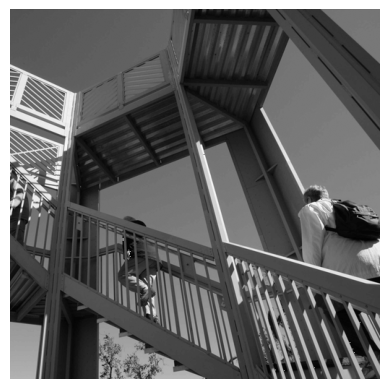

In [2]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

We can see that this is an image of a stairwell. There are lots of features in here that we can play with seeing if we can isolate them -- for example there are strong vertical lines.

The image is stored as a numpy array, so we can create the transformed image by just copying that array. Let's also get the dimensions of the image so we can loop over it later.

In [3]:
i_transformed = np.copy(i)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

Now we can create a filter as a 3x3 array.

In [8]:
# This filter detects edges nicely
# It creates a convolution that only passes through sharp edges and straight
# lines.

#Experiment with different values for fun effects.
#filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]

# A couple more filters to try for fun!
#filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# If all the digits in the filter don't add up to 0 or 1, you
# should probably do a weight to get it to do so
# so, for example, if your weights are 1,1,1 1,2,1 1,1,1
# They add up to 10, so you would set a weight of .1 if you want to normalize them
weight  = 1

Now let's create a convolution. We will iterate over the image, leaving a 1 pixel margin, and multiply out each of the neighbors of the current pixel by the value defined in the filter.

i.e. the current pixel's neighbor above it and to the left will be multiplied by the top left item in the filter etc. etc. We'll then multiply the result by the weight, and then ensure the result is in the range 0-255

Finally we'll load the new value into the transformed image.

In [9]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (i[x - 1, y-1] * filter[0][0])
      convolution = convolution + (i[x, y-1] * filter[1][0])
      convolution = convolution + (i[x + 1, y-1] * filter[2][0])
      convolution = convolution + (i[x-1, y] * filter[0][1])
      convolution = convolution + (i[x, y] * filter[1][1])
      convolution = convolution + (i[x+1, y] * filter[2][1])
      convolution = convolution + (i[x-1, y+1] * filter[0][2])
      convolution = convolution + (i[x, y+1] * filter[1][2])
      convolution = convolution + (i[x+1, y+1] * filter[2][2])
      convolution = convolution * weight
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255
      i_transformed[x, y] = convolution

Now we can plot the image to see the effect of the convolution!

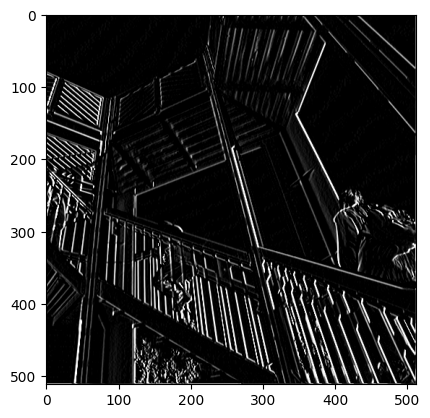

In [10]:
# Plot the image. Note the size of the axes -- they are 512 by 512
plt.gray()
plt.grid(False)
plt.imshow(i_transformed)
#plt.axis('off')
plt.show()

So, consider the following filter values, and their impact on the image.

Using -1,0,1,-2,0,2,-1,0,1 gives us a very strong set of vertical lines:

![Detecting vertical lines filter](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig2.png)

Using -1, -2, -1, 0, 0, 0, 1, 2, 1 gives us horizontal lines:

![Detecting horizontal lines](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig3.png)

Explore different values for yourself!

## Pooling

As well as using convolutions, pooling helps us greatly in detecting features. The goal is to reduce the overall amount of information in an image, while maintaining the features that are detected as present.

There are a number of different types of pooling, but for this lab we'll use one called MAX pooling.

 The idea here is to iterate over the image, and look at the pixel and it's immediate neighbors to the right, beneath, and right-beneath. Take the largest (hence the name MAX pooling) of them and load it into the new image. Thus the new image will be 1/4 the size of the old -- with the dimensions on X and Y being halved by this process. You'll see that the features get maintained despite this compression!

![Max Pooling](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig4.png)

This code will show (4, 4) pooling. Run it to see the output, and you'll see that while the image is 1/4 the size of the original in both length and width, the extracted features are maintained!



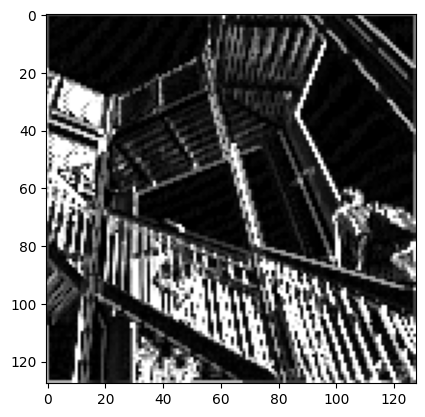

In [12]:
new_x = int(size_x/4)
new_y = int(size_y/4)
newImage = np.zeros((new_x, new_y))
for x in range(0, size_x, 4):
  for y in range(0, size_y, 4):
    pixels = []
    pixels.append(i_transformed[x, y])
    pixels.append(i_transformed[x+1, y])
    pixels.append(i_transformed[x+2, y])
    pixels.append(i_transformed[x+3, y])
    pixels.append(i_transformed[x, y+1])
    pixels.append(i_transformed[x+1, y+1])
    pixels.append(i_transformed[x+2, y+1])
    pixels.append(i_transformed[x+3, y+1])
    pixels.append(i_transformed[x, y+2])
    pixels.append(i_transformed[x+1, y+2])
    pixels.append(i_transformed[x+2, y+2])
    pixels.append(i_transformed[x+3, y+2])
    pixels.append(i_transformed[x, y+3])
    pixels.append(i_transformed[x+1, y+3])
    pixels.append(i_transformed[x+2, y+3])
    pixels.append(i_transformed[x+3, y+3])
    pixels.sort(reverse=True)
    newImage[int(x/4),int(y/4)] = pixels[0]

# Plot the image. Note the size of the axes -- now 128 pixels instead of 512
plt.gray()
plt.grid(False)
plt.imshow(newImage)
#plt.axis('off')
plt.show()



In the next lab you'll see how to add convolutions to your Fashion MNIST neural network to make it more efficient -- because it will classify based on features, and not on raw pixels.